# Data-mining в прогнозировании финансовых временных рядов 

Финансовые временные ряды представляют собой объемные массивы информации по котировкам и объемам торгов акций, валют и других биржевых и внебиржевых инструментов. Анализ и прогнозирование таких рядов всегда представляли особый интерес как для исследователей-аналитиков, так и для инвесторов-практиков. Однако финансовые временные ряды имеют свою специфику, не позволяющую найти единственно верный и работающий метод прогнозирования. Современные технологии позволяют тестировать и применять сложные методы прогнозирования, требующие объемных вычислений. Примером такого современного подхода являются методы Data Mining.
<br>
<br>
    Целью настоящей работы является анализ возможности применения методов Data Mining к финансовым временным рядам. Данные методы были рассмотрены в сравнении с другими распространенными методами прогнозирования финансовых временных рядов: ARIMA, скользящие средние и регрессионный анализ. Для реализации методов был разработан программный алгоритм на языке Python.


In [3]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

С целью прогнозирования финансовых временных рядов мы решили рассмотреть акции ПАО “СберБанк” за 2019-2024 гг. Поскольку банковский сектор сильно сконцентрирован на крупнейших игроках, нам показалось интересным взять за основу акции Сбербанка, который отчитался лучше консенсус-прогнозов в течение 2023 г. 

In [14]:
# загрузим датасет, включающий данные о котировках акции с 2019 по 2024 гг.
df = pd.read_csv('SBER_190501_240331.csv', sep = ';')
df = df[['<DATE>','<CLOSE>']]
df

,<DATE>,<CLOSE>
0,02/05/19,229.10
1,03/05/19,232.52
2,06/05/19,232.80
3,07/05/19,231.49
4,08/05/19,230.00
...,...,...
1220,26/03/24,294.11
1221,27/03/24,295.10
1222,28/03/24,299.00
1223,29/03/24,298.72


In [15]:
# приведем к более удобному виду названия столбцов
df = df.rename(columns={'<CLOSE>': 'Close'})
df = df.rename(columns={'<DATE>': 'Date'})

In [6]:
import datetime

def str_to_datetime(s):
    split = s.split('/')
    year,month,day = int(split[2]),int(split[1]),int(split[0])
    return datetime.datetime(year=2000+year,month=month,day= day)

datetime_object = str_to_datetime('02/05/19')
datetime_object

datetime.datetime(2019, 5, 2, 0, 0)

In [7]:
# преобразуем даты в нужный формат
df['Date']=df['Date'].apply(str_to_datetime)
df['Date']

0      2019-05-02
1      2019-05-03
2      2019-05-06
3      2019-05-07
4      2019-05-08
          ...    
1220   2024-03-26
1221   2024-03-27
1222   2024-03-28
1223   2024-03-29
1224   2024-04-01
Name: Date, Length: 1225, dtype: datetime64[ns]

In [8]:
df.index = df.pop('Date')
df

,Close
Date,
2019-05-02,229.10
2019-05-03,232.52
2019-05-06,232.80
2019-05-07,231.49
2019-05-08,230.00
...,...
2024-03-26,294.11
2024-03-27,295.10
2024-03-28,299.00


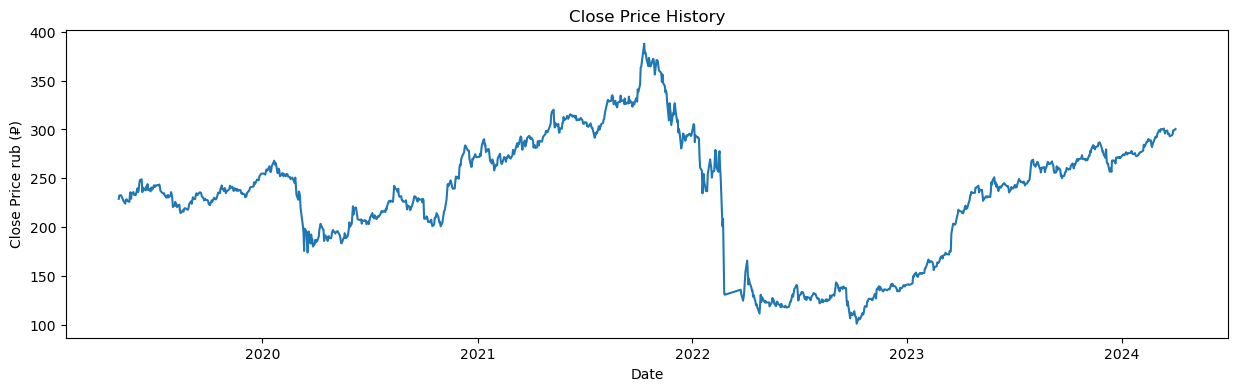

In [9]:
# визуализируем динамику котировок акции
plt.figure(figsize=(15,4))
plt.title('Close Price History')
plt.plot(df.index,df['Close'])
plt.xlabel('Date',fontsize=10)
plt.ylabel('Close Price rub (₽)',fontsize=10)
plt.show()

# Скользящие средние

Рассчитаем скольхщие средние периода 10,50 и 100. Значит, среднее значение акции будет вычисляться из средней цены за последние 10, 50 и 100 дней. При каждом новом дне скользящее среднее будет обновляться, отбрасывая самое старое значение и добавляя новое значение за текущий день.

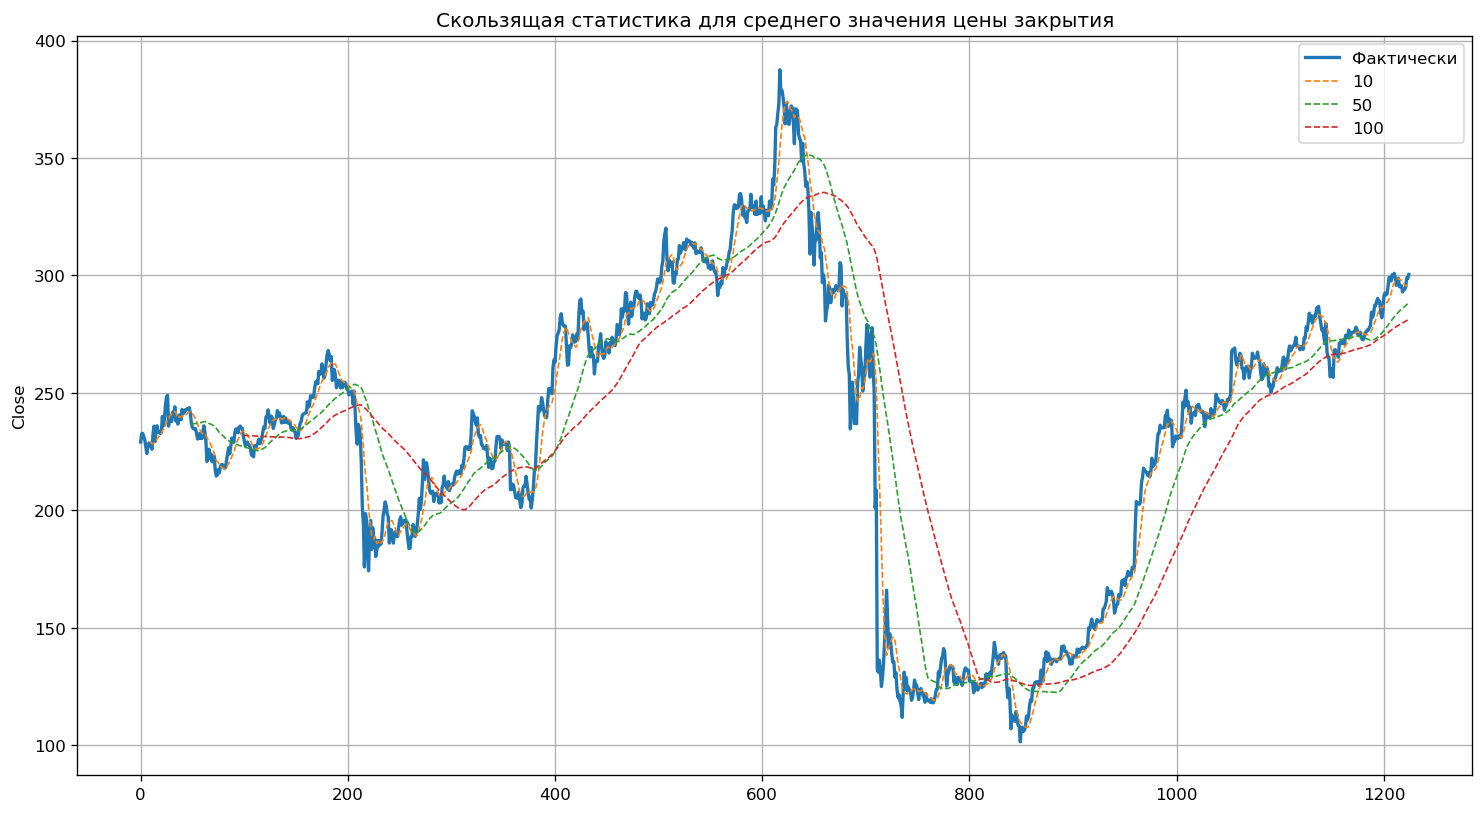

In [16]:
report = df.copy()
report['mean_10'] = report['Close'].rolling(window=10).mean()
report['mean_50'] = report['Close'].rolling(window=50).mean()
report['mean_100'] = report['Close'].rolling(window=100).mean()

    # визуализируем
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=report, x=report.index, y='Close', ax=ax, lw=2, label='Фактически')
sns.lineplot(data=report, x=report.index, y='mean_10', ax=ax, linestyle='--', lw=1, label='10')
sns.lineplot(data=report, x=report.index, y='mean_50', ax=ax, linestyle='--', lw=1, label='50')
sns.lineplot(data=report, x=report.index, y='mean_100', ax=ax, linestyle='--', lw=1, label='100')
ax.set_title(f"Скользящая статистика для среднего значения цены закрытия")
ax.legend()
plt.grid()
plt.show()

**Смысл использования скользящих средних:** помощь трейдерам и инвесторам определить общую направленность движения цен акций. Они могут быть использованы для выявления сигналов *покупки или продажи акций*, а также для определения уровней поддержки и сопротивления.

Например, если текущая цена акции превышает свою скользящую среднюю на 50 дней, это может указывать на подтверждение восходящего тренда *(нужно покупать акции)*. С другой стороны, если текущая цена акции падает ниже своей скользящей средней, это может указывать на начало нисходящего тренда *(нужно скорее продавать)*.

Также можно обратить внимание на **пересечение скользящих средних**. Это может быть также сигналом для инвесторов. Покупать акцию надо, когда быстрая скользящая средняя пересекают медленную (быстрая имеет маленький период, а медленная большой). Открывать позицию надо в ту сторону, куда пошла быстрая скользящая средняя. Причём желательно, чтобы направление большой скользящей средней было направлено в сторону входа в позицию. Чем больше период, тем больше будет запаздывание входа в сделку, но тем более точные будут входы. Невозможно выбрать значения скользящих средних, которые бы давали всегда на 100% верный сигнал. Помимо прибыльных входов, всегда будут ещё и ложные сигналы. Поэтому, как и в любой стратегии рекомендуется использовать защитную остановку (стоп-лосс).

Также на графиках, есть точка, в которой пересекаются все скользящие средние. В большинстве случаев это январь 2023 года. **Пересечение трёх скользящих — сильный сигнал**. Сигналом на покупку является пересечение самой быстрой (период 10) скользящей двух других. При этом требованием является то, чтобы все скользащие средние были направлены под углом в одну сторону: либо вверх для сигнала на покупку, либо вниз для сигнала на продажу.

# <a id="7"></a>
# Экспоненциальные скользящие средние

_Почему экспоненциальные?_

Так как рассматриваемый показатель - цена акции, а этот показатель очень подвержен колебаниям, то тут стоит вычислять среднее, уделяя бОльшее внимание на более близкий старый показатель. Это позволяет сделать экпоненциальное среднее. Он отдает больший вес более новым значениям и меньший вес более старым значениям. Это позволяет быстрее реагировать на изменения в данных, особенно на более коротких периодах. Поскольку экпоненциальное среднее уделяет больше внимания более свежим данным, она может помочь выявить поворотные точки или сигналы быстрее, чем обычные скользящие средние.

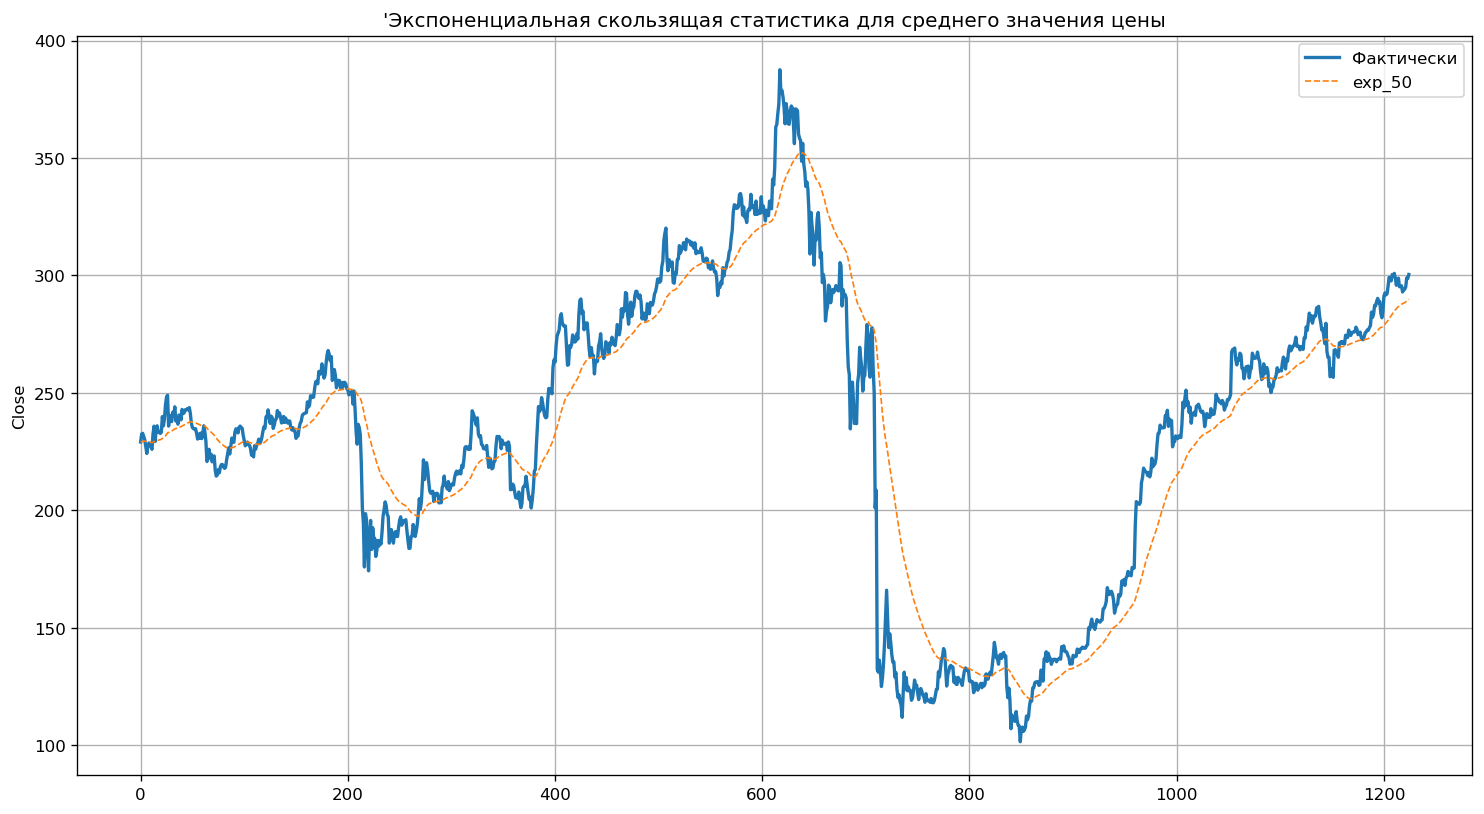

In [17]:
report = df.copy()
report['exp_mean_50'] = report['Close'].ewm(span=50, adjust=False).mean() # расчет экпоненциальной средней

    # визуализируем
fig, ax = plt.subplots(figsize=(15, 8))
sns.lineplot(data=report, x=report.index, y='Close', ax=ax, lw=2, label='Фактически')
sns.lineplot(data=report, x=report.index, y='exp_mean_50', ax=ax, linestyle='--', lw=1, label='exp_50') # график средней
ax.set_title(f"'Экспоненциальная скользящая статистика для среднего значения цены")
ax.legend()
plt.grid()
plt.show()

График экспоненциальной скользящей средней более плавный, что позволяет легче понимать динамику цены акции.

### Проверка однородности

Проведем тест Харки — Бера для определения номарльности распределения, чтобы выдвинуть предположение об однородности временного ряда.
</br>
H0: данные распределены нормально

In [18]:
jb_test = sm.stats.stattools.jarque_bera(df['Close'].values)

print("Jarque-Bera Test Results:")
print(f"JB value: {jb_test[0]}")
print(f"P-value: {jb_test[1]}")
print(f"Skewness: {jb_test[2]}")
print(f"Kurtosis: {jb_test[3]}")

Jarque-Bera Test Results:
JB value: 32.64153942132405
P-value: 8.165443427616985e-08
Skewness: -0.3055708164138626
Kurtosis: 2.484234921949618


p_value < alf (0,05) => отвергаем Н0, делаем вывод, что данные неоднородны.

### Проверка стационарности 

Нулевая гипотеза расширенного теста Дики-Фуллера (ADF) заключается в том, что временной ряд не является стационарным. 

In [19]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
import pandas as pd

res = adfuller(df['Close'].values)
print('Augmented Dickey-Fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])

Augmented Dickey-Fuller Statistic: -1.247392
p-value: 0.652884


Так как p-value > alf => нет оснований отвергнуть Н0. При проведении расширеннего теста Дики-Фуллера, была выявлена нестационарность временного ряда.

Для решения проблемы нестационарности ряд дифференцируют до достижения стационарности. Для исходного временного ряда был построен дважды продифференцированный временной ряд, который согласно тесту Дики-Фуллера уже является стационарным (p-value < alfa):

In [20]:
data = df['Close']

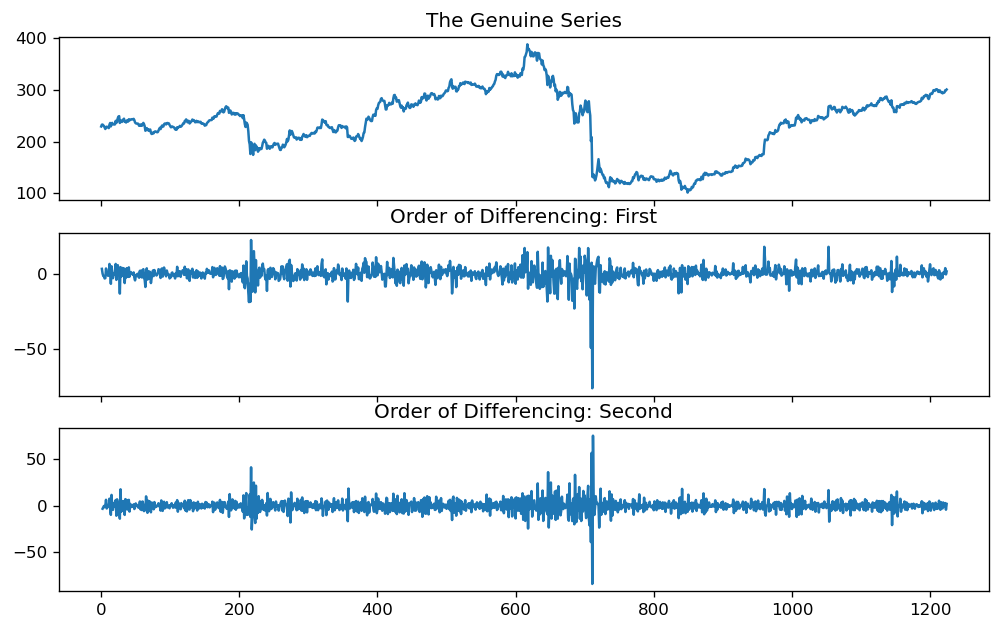

In [21]:
plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})

# график динамики котировок
fig, axes = plt.subplots(3, 1, sharex=True)
axes[0].plot(data.values); axes[0].set_title('The Genuine Series')

# ряд первых разностей
axes[1].plot(pd.Series(data.values).diff()); axes[1].set_title('Order of Differencing: First')


# ряд вторых разностей
axes[2].plot(pd.Series(data.values).diff().diff()); axes[2].set_title('Order of Differencing: Second')


plt.show()

In [22]:
#тест Дики-Фуллера
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(pd.Series(data.values).diff(2).dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -6.330258e+00
p-value                        2.918142e-08
#Lags Used                     2.300000e+01
Number of Observations Used    1.199000e+03
Critical Value (1%)           -3.435816e+00
Critical Value (5%)           -2.863954e+00
Critical Value (10%)          -2.568055e+00
dtype: float64


Ряд вторых разностей стационарен, поэтому он будет использован для построения дальнейших моделей.

# Прогнозирование методами Data-mining

Для прогнозирования финансового временного ряда мы воспользовались такими методами Data-mining как рекуррентная нейронная сеть LSTM и регрессия опорных векторов SVR.   Данные за 1125 дней были разделены на 2 части (75% и 25% соответственно). Обучение моделей производилось на 75% всех данных. 

<AxesSubplot:xlabel='Date'>

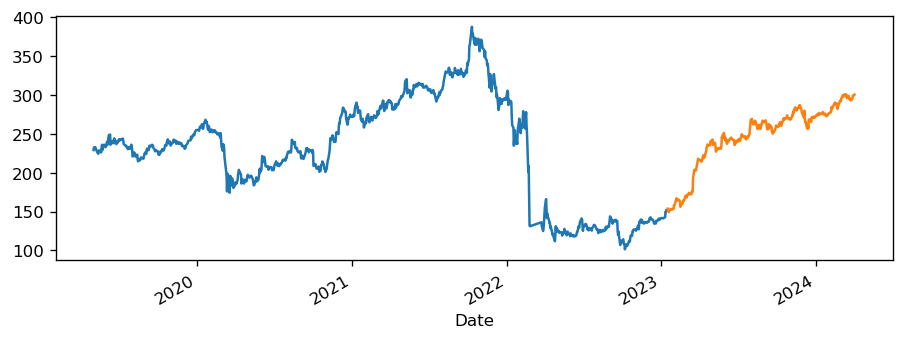

In [ ]:
train = df[:int(0.75*(len(df)))]
test = df[int(0.75*(len(df))):]

#plotting the data
train['Close'].plot()
test['Close'].plot()

# LSTM

Долгосрочная краткосрочная память (LSTM) — это архитектура искусственной рекуррентной нейронной сети (RNN), используемая в области глубокого обучения. В отличие от стандартных нейронных сетей прямой связи, LSTM имеет соединения обратной связи. Он может обрабатывать не только отдельные точки данных (например, изображения), но и целые последовательности данных (например, речь или видео).

In [ ]:
import mplfinance as mpf


# Data normalization
from sklearn.preprocessing import MinMaxScaler


# Keras & sklearn imports
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping

Для масштабирования данных так, чтобы все функции имели одинаковые диапазоны и распределения, проведет нормализацию. Мы использовали функцию MinMaxScaler из библиотеки sklearn, которая масштабирует данные до диапазона (-1, 1).Этот шаг предварительной обработки может помочь улучшить производительность модели машинного обучения.

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_set= train.values.reshape(-1,1)
train_sc = scaler.fit_transform(train_set)

test_set= test.values.reshape(-1,1)
test_sc = scaler.fit_transform(test_set)

In [ ]:
predict_days = 1 # модель будет обучена делать прогнозы на следующий день на основе данных предыдущего дня.
X_train = train_sc[:-predict_days] # модель будет обучена на всех данных, кроме последнего дня
y_train = train_sc[predict_days:] # модель будет протестирована на всех данных, кроме первого дня

X_test = test_sc[:-predict_days] # модель будет обучена предсказывать последний день обучающих данных
y_test = test_sc[predict_days:] # будут протестированы для прогнозирования данных первого дня тестирования

In [ ]:
# перед обучением проверим форму
X_train = X_train.reshape((X_train.shape[0],1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0],1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(917, 1, 1) (917, 1) (306, 1, 1) (306, 1)


### Построение LSTM модели

In [ ]:
from keras.models import Sequential
import tensorflow as tf

In [ ]:
# Построение LSTM модели
lstm_model = Sequential()

# количество нейронов подобрано эмпирически
lstm_model.add(LSTM(units=100, return_sequences=False, input_shape=(X_train.shape[1],1)))

# Forgetting layer подобран эмпирически
lstm_model.add(Dropout(0.2))

# Output layer : Number of output data
lstm_model.add(Dense(1))

#loss : Loss function
#optimizer : Optimizer
#metrics : Evaluation metrics

lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=[tf.metrics.MeanAbsoluteError()])

#Use EarlyStopping to avoid wasting time
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

history_lstm_model = lstm_model.fit(X_train, y_train, epochs=30, batch_size=1, verbose=2, shuffle=True, callbacks=[early_stop])

Epoch 1/30
840/840 - 2s - 3ms/step - loss: 43856.4961 - mean_absolute_error: 196.3805
Epoch 2/30
840/840 - 1s - 1ms/step - loss: 28486.2422 - mean_absolute_error: 152.7284
Epoch 3/30
840/840 - 1s - 1ms/step - loss: 18739.0332 - mean_absolute_error: 116.7619
Epoch 4/30
840/840 - 1s - 1ms/step - loss: 12466.2080 - mean_absolute_error: 92.7104
Epoch 5/30
840/840 - 1s - 1ms/step - loss: 8728.2139 - mean_absolute_error: 78.1824
Epoch 6/30
840/840 - 1s - 1ms/step - loss: 6299.0381 - mean_absolute_error: 66.5258
Epoch 7/30
840/840 - 1s - 1ms/step - loss: 4897.0132 - mean_absolute_error: 57.8807
Epoch 8/30
840/840 - 1s - 1ms/step - loss: 4114.5474 - mean_absolute_error: 52.8746
Epoch 9/30
840/840 - 1s - 1ms/step - loss: 3269.3169 - mean_absolute_error: 45.9741
Epoch 10/30
840/840 - 1s - 1ms/step - loss: 2864.6660 - mean_absolute_error: 42.9081
Epoch 11/30
840/840 - 1s - 1ms/step - loss: 2497.3857 - mean_absolute_error: 39.2609
Epoch 12/30
840/840 - 1s - 1ms/step - loss: 2086.2864 - mean_absolu

In [ ]:
lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,705 (479.32 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 81,804 (319.55 KB)

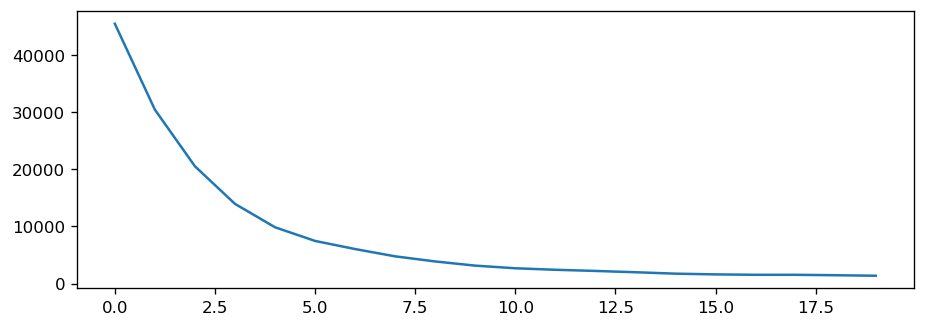

In [ ]:
# The training history for the loss
plt.plot(history_lstm_model.history['loss'])

In [ ]:
y_pred_test_lstm = lstm_model.predict(y_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [ ]:
# восстановим нормализованные данные
reduction_Lstm_pred = scaler.inverse_transform(y_pred_test_lstm)
reduction_y_test = scaler.inverse_transform(y_test)

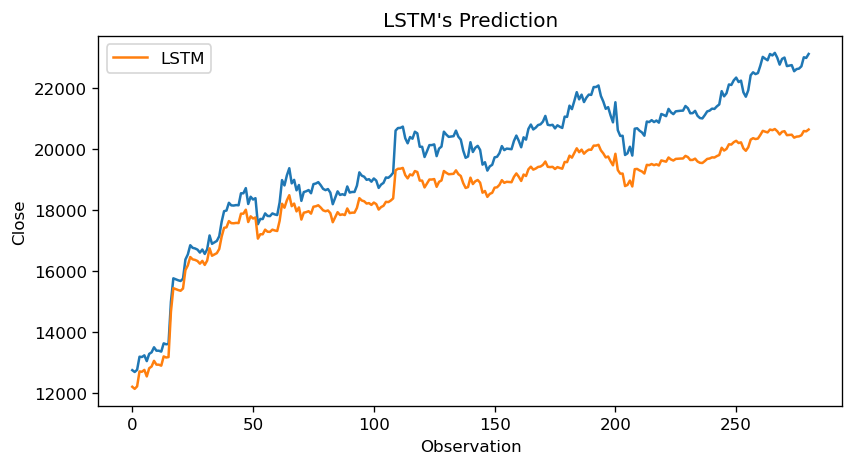

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(reduction_y_test)
plt.plot(reduction_Lstm_pred, label='LSTM')
plt.title("LSTM's Prediction")
plt.xlabel('Observation')
plt.ylabel('Close')
plt.legend()
plt.show();

In [ ]:
print("Mean Absolute Error:", mean_absolute_error(reduction_y_test, reduction_Lstm_pred))
print('Mean Squared Error:', mean_squared_error(reduction_y_test, reduction_Lstm_pred))
print('Root Mean Squared Error:', sqrt(mean_squared_error(reduction_y_test, reduction_Lstm_pred)))
print("Coefficient of Determination:", r2_score(reduction_y_test, reduction_Lstm_pred))

Mean Absolute Error: 1165.4905292429303
Mean Squared Error: 1687437.363375344
Root Mean Squared Error: 1299.013996604865
Coefficient of Determination: 0.685042887319534


В начале обучения LSTM-модель дает прогнозы, близкие к фактическим значениям, но по мере того, как модель "узнает" данные и "привыкает" к ним, ее прогнозы становятся менее подвержены резким колебаниям и в целом становятся более устойчивыми и плавными. 

# SVM

Машины опорных векторов (SVM) — это тип алгоритма обучения с учителем, который можно использовать для задач классификации или регрессии. SVM часто используются для прогнозирования цен на акции, поскольку они могут обрабатывать сложные нелинейные зависимости между входными признаками и целевой переменной.

In [79]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

In [78]:
train = df[:int(0.75*(len(df)))]
test = df[int(0.75*(len(df))):]

In [80]:
train_set = train.values.reshape(-1, 1)
train_sc = scaler.fit_transform(train_set)

test_set = test.values.reshape(-1, 1)
test_sc = scaler.transform(test_set)

predict_days = 50 # подобрано эмпирически 

X_train, y_train = [], []
for i in range(len(train_sc) - predict_days):
    X_train.append(train_sc[i:i+predict_days])
    y_train.append(train_sc[i+predict_days][0])

X_test, y_test = [], []
for i in range(len(test_sc) - predict_days):
    X_test.append(test_sc[i:i+predict_days])
    y_test.append(test_sc[i+predict_days][0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_test, y_test = np.array(X_test), np.array(y_test)

In [81]:
parameters = {'C': [0.1, 0.2], 'gamma': [0.001, 0.003, 0.0001]}
svr_model = SVR(kernel='rbf')

grid_search = GridSearchCV(svr_model, parameters, cv=3)

grid_search.fit(X_train.reshape(X_train.shape[0], -1), y_train)
best_model = grid_search.best_estimator_
best_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

SVR(C=0.2, gamma=0.003)

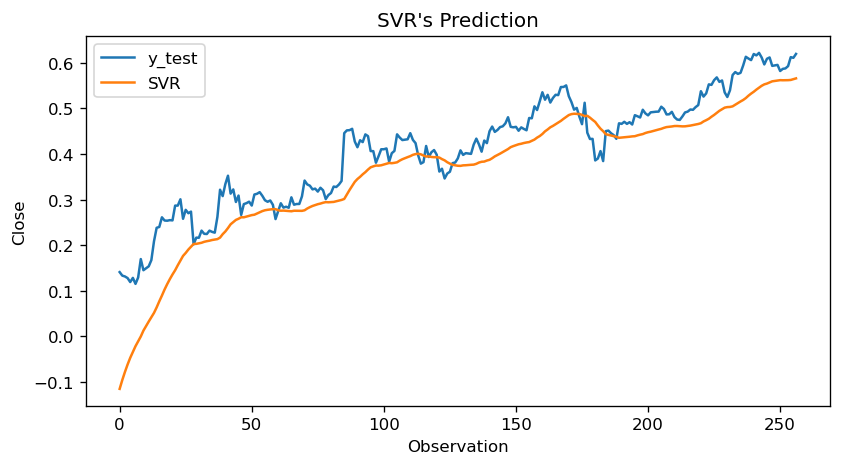

In [82]:
predictions = best_model.predict(X_test.reshape(X_test.shape[0], -1))
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='y_test')
plt.plot(predictions, label='SVR')
plt.title("SVR's Prediction")
plt.xlabel('Observation')
plt.ylabel('Close')
plt.legend()
plt.show();

In [54]:
print("Mean Absolute Error:", mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', sqrt(mean_squared_error(y_test, predictions)))
print("Coefficient of Determination:", r2_score(y_test, predictions))
print("MAPE", mean_absolute_percentage_error(y_test, predictions))

Mean Absolute Error: 0.04889226110111994
Mean Squared Error: 0.004204994114377099
Root Mean Squared Error: 0.0648459259659163
Coefficient of Determination: 0.8048670197967353
MAPE 1.6388661054490063


Рассчитаем информационный критерий

In [57]:
from sklearn.svm import SVR
import numpy as np

num_params = 1  
num_observations = len(X_train)
RSS = np.sum((y_test - predictions)**2)

# Рассчитаем AIC
AIC = 2 * num_params + num_observations * np.log(RSS / num_observations)

print("AIC value:", AIC)

AIC value: -5803.703077016393


Полученный график прогноза модели SVR характеризуется большей плавностью и напоминает кривую скользящего среднего. В результате эксперимента было установлено, что наивысшая точность прогноза достигается при учете 50 предшествующих значений цены. 

## Для сравнения методов Data-mining с методами ARIMA, скользящих средних и регрессионного анализа был осуществлен прогноз цен акций за тот же временной промежуток.

# ARIMA

Для определения параметров модели необходимо построить коррелограммы. В пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций.

C:\Users\An_to\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


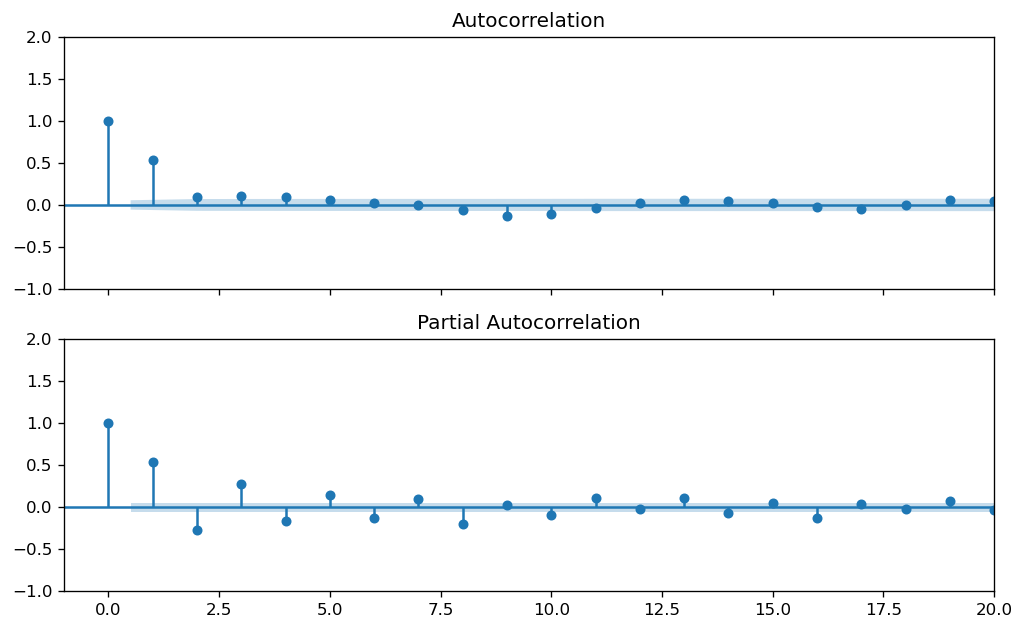

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize':(10,6), 'figure.dpi':120})

fig, axes = plt.subplots(2, 1, sharex=True)

diff2 = pd.Series(data.values).diff(2).dropna()

plot_acf(diff2, ax=axes[0])
axes[0].set(xlim =(-1,20))
axes[0].set(ylim =(-1,2))


plot_pacf(diff2, ax=axes[1])
axes[1].set(xlim =(-1,20))
axes[1].set(ylim =(-1,2))
plt.show()

По коррелограмме ACF можно увидеть, что q = 2, т.к. после лага 2 значении функций резко падают.

После изучения коррелограммы PACF можно сделать вывод, что p = 0, т.к. на ней только 0 лаг сильно отличнен от нуля.

Параметры p, d, q модели ARIMA были найдены с помощью анализа автокорреляционной (ACF) и частной автокорреляционной (PACF) функции для ряда вторых разностей. Так, модель ARIMA была построена с параметрами (0, 2, 3).  

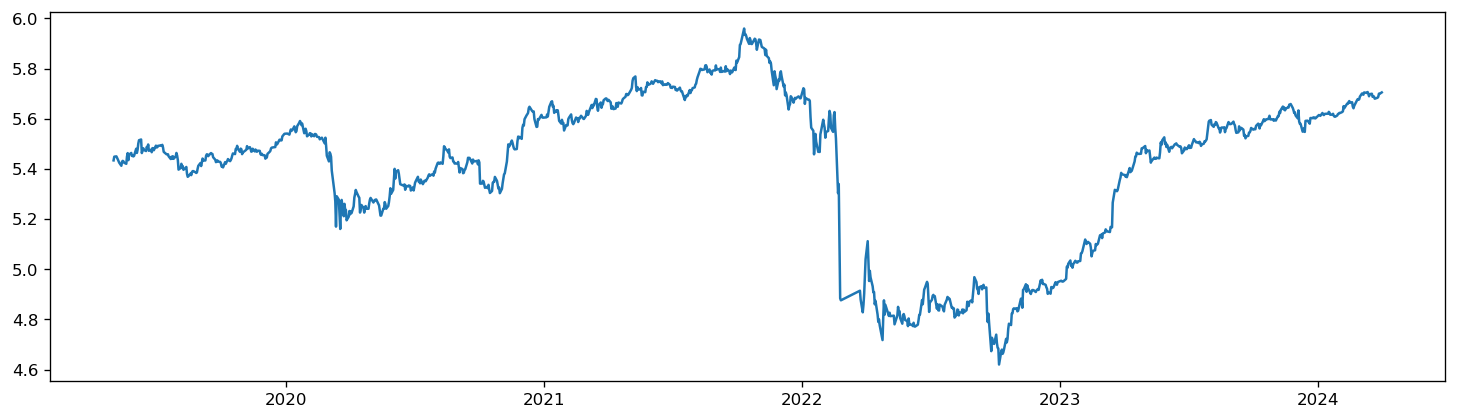

In [70]:
df = np.log(df) 
plt.figure(figsize=(15,4))
plt.plot(df)
plt.show()

In [71]:
split_index = int(len(df_diff) * 0.80) # тренировочная выборка 80% была подобрана эмпирически

# Создание обучающего и тестового наборов
df_train = df['Close'].values[:split_index]
df_test = df['Close'].values[split_index:]

In [72]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df_train, order=(0,2,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  980
Model:                 ARIMA(0, 2, 3)   Log Likelihood                2130.600
Date:                Thu, 11 Apr 2024   AIC                          -4253.201
Time:                        13:09:36   BIC                          -4233.659
Sample:                             0   HQIC                         -4245.765
                                - 980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0259      0.023    -45.358      0.000      -1.070      -0.982
ma.L2          0.1105      0.028      3.942      0.000       0.056       0.165
ma.L3         -0.0745      0.015     -4.840      0.0

Text(0.5, 1.0, "ARIMA's predictions")

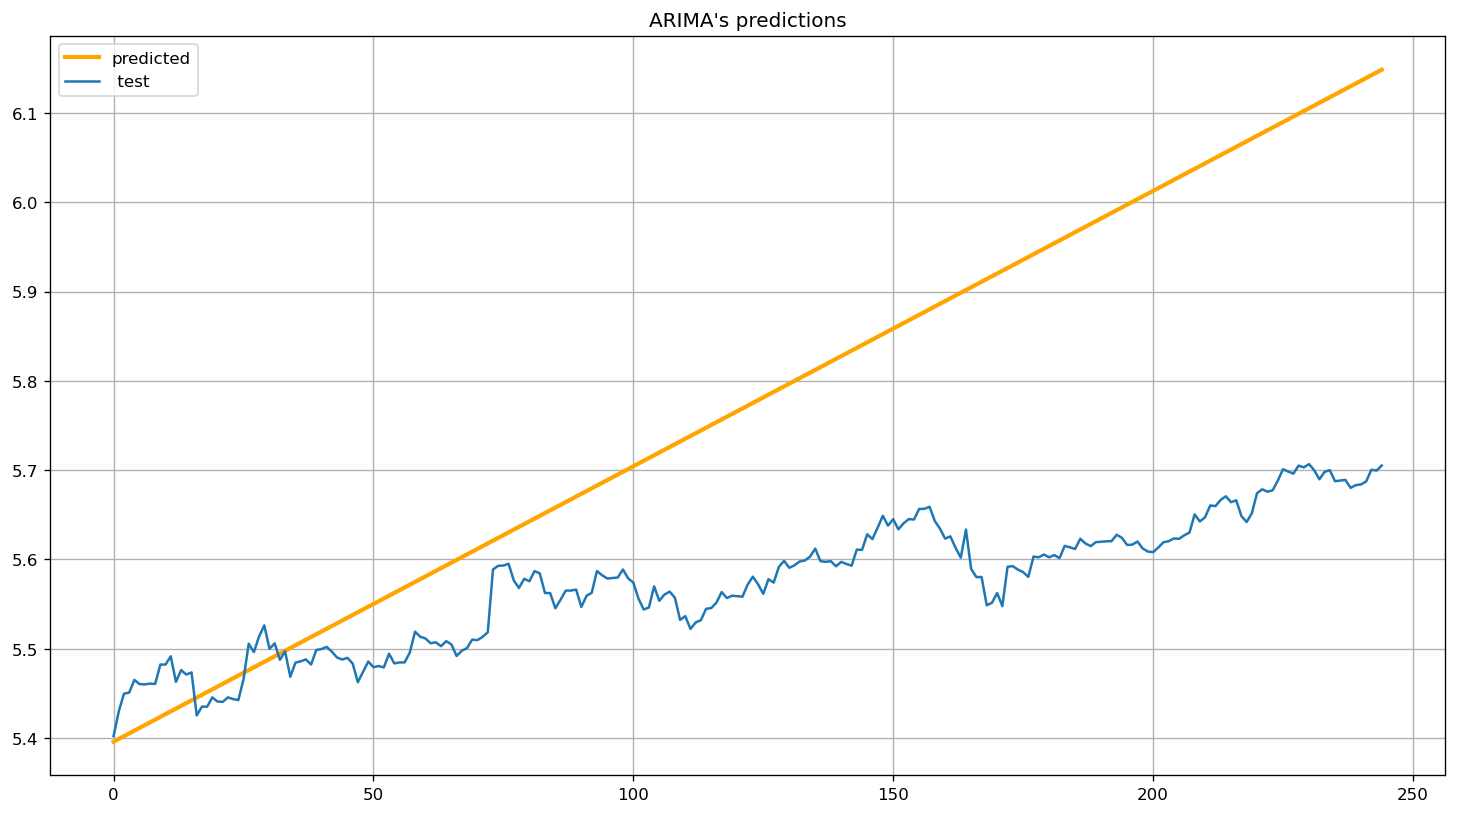

In [73]:
forecast_test = model_fit.forecast(len(df_test))

forecast_manual = list(forecast_test)

plt.figure(figsize=(15, 8))
plt.plot(forecast_manual, color='orange', linewidth=2.5)
plt.plot(df_test)
plt.legend(['predicted', ' test'])
plt.grid()
plt.title(f"ARIMA's predictions")

In [74]:
# Printout relevant metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from math import sqrt


print("Mean Absolute Error:", mean_absolute_error(df_test, forecast_test))
print('Mean Squared Error:', mean_squared_error(df_test, forecast_test))
print('Root Mean Squared Error:', sqrt(mean_squared_error(df_test, forecast_test)))
print("Coefficient of Determination:", r2_score(df_test, forecast_test))
print("MAPE", mean_absolute_percentage_error(df_test, forecast_test))

Mean Absolute Error: 0.20654787734171517
Mean Squared Error: 0.06331074094628787
Root Mean Squared Error: 0.2516162573171453
Coefficient of Determination: -11.061356681195013
MAPE 0.036788149811494544


# Модель SimpleExpSmoothing

In [27]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

Следующим выбранным методом прогнозирования стал метод с использованием простого экспоненциального сглаживания. Учитывая высокую волатильность цены акции, целесообразно использовать взвешенное среднее, придавая больший вес последним значениям и меньший вес более старым.  Это позволяет сделать экспоненциальное среднее. В Python такой подход был реализован с помощью модели SimpleExpSmoothing.

 Данная модель является простым и легко понятным методом прогнозирования временных рядов. SES обладает хорошей способностью адаптироваться к изменениям в данных. Он дает больший вес более свежим наблюдениям, что позволяет быстрее реагировать на динамику ряда. В нашем случае, наибольший вес будет придаваться последним **14 дням.**

_НО!_
Удачен такой метод только в стационарных сериях, не должно быть трендов и сезонности. В целом, спорный вопрос является ли наш временной вариант таким. Всё-таки по ранее сделанным расчетам не было выявлено определенных трендов и сезонности, поэтому смело используем такой вариант.

C:\Users\An_to\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Text(0.5, 1.0, "SimpleExpSmoothing's predictions")

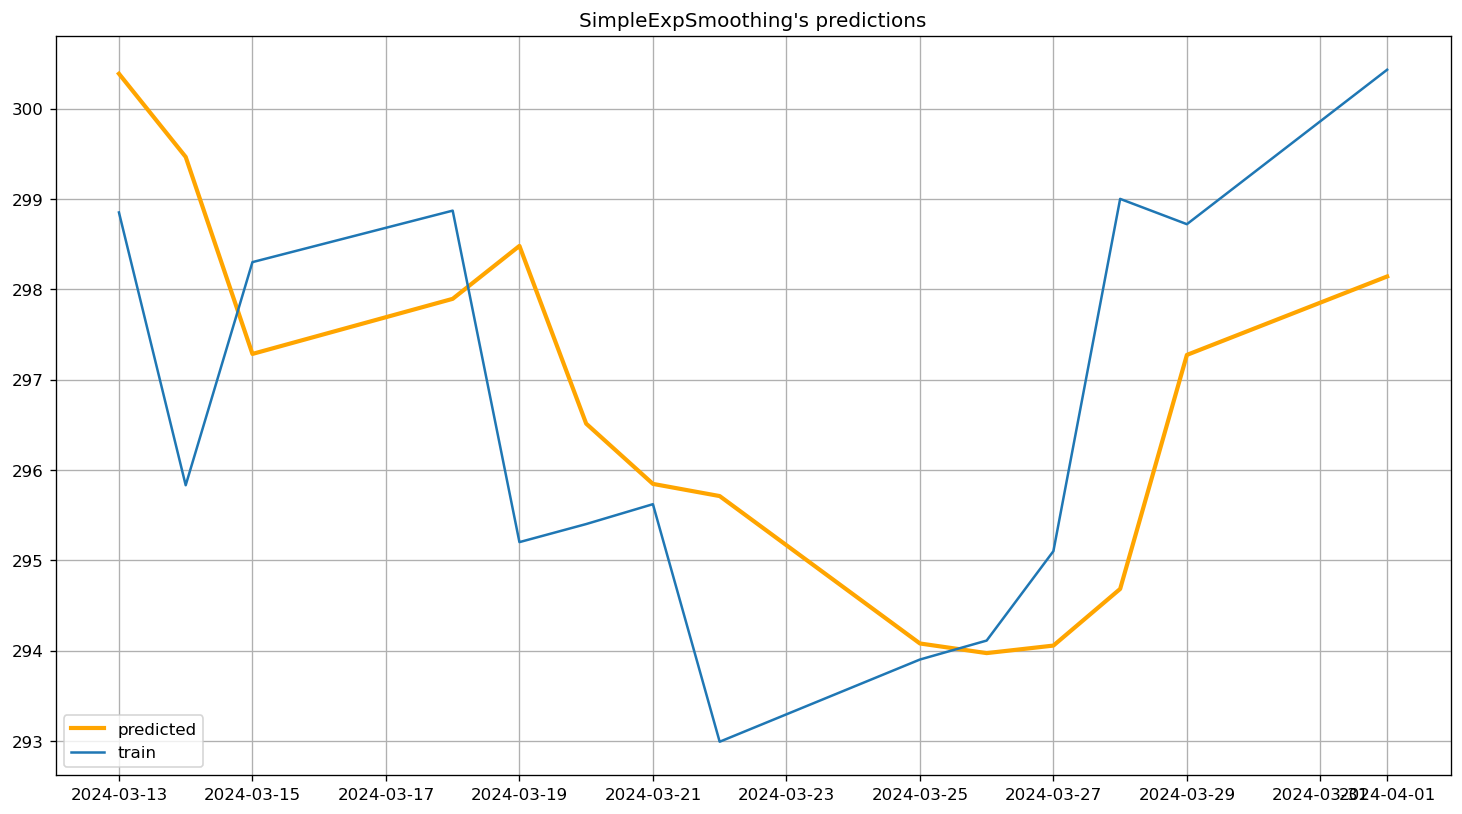

In [28]:
learning_rate = 14
test_size = 14

df_diff = df['Close']

train = df_diff[-learning_rate - test_size:] # участок списка, начиная с learning_rate + test_size элемента и до конца
test = df_diff[-test_size:] # берем последние 14 элементов списка.


fit2 = SimpleExpSmoothing(train).fit(smoothing_level=0.6,optimized=False) #  60%-предыдущие сглаженные значения, 40% - текущее значение
predicted = fit2.predict(test_size)

# визуализируем
plt.figure(figsize=(15, 8))
plt.plot(predicted, color='orange',  linewidth=2.5)
plt.plot(test)
plt.legend(['predicted', 'train', ' test'])
plt.grid()
plt.title(f"SimpleExpSmoothing's predictions")

In [31]:
print("Mean Absolute Error:", mean_absolute_error(test, predicted))
print('Mean Squared Error:', mean_squared_error(test, predicted))
print('Root Mean Squared Error:', sqrt(mean_squared_error(test, predicted)))
print("Coefficient of Determination:", r2_score(test, predicted))
print("MAPE", mean_absolute_percentage_error(test, predicted))

Mean Absolute Error: 1.7082316720337474
Mean Squared Error: 4.579736450073628
Root Mean Squared Error: 2.1400318806208536
Coefficient of Determination: 0.10643950060302809
MAPE 0.005752882732157997


In [33]:
AIC = fit2.aic
print("AIC value:", AIC)

AIC value: 58.133735851928314


# Linear Regression

В качестве признака-фактора в регрессионном анализе были взяты скользящие экспоненциальные средние, а в качестве признака-результата - цена закрытия акции. Для анализа данных мы выбрали окно EMA длиной в 50 дней. В зависимости от экономической обстановки, окно EMA можно варьировать: чем больше окно, тем выше ожидания стабильности на фондовом рынке. 

In [84]:
import pandas_ta

df_1 = df.copy(deep=True)
df_1.ta.ema(close='Close', length=50, append=True)[50:] 
df_1.head(3)

,Close,EMA_50
Date,,
2019-05-02,5.434159,NaN
2019-05-03,5.448976,NaN
2019-05-06,5.450180,NaN


In [85]:
df_1 = df_1.dropna(axis = 0, how ='any') 
df_1.head(3)

,Close,EMA_50
Date,,
2019-07-12,5.468145,5.466475
2019-07-15,5.460734,5.466250
2019-07-16,5.458521,5.465947


In [86]:
# разделим на тестовую и тренировочные выборки
train = df_1[:int(0.75*(len(df_1)))]
test = df_1[int(0.75*(len(df_1))):]

In [87]:
y_train = train['Close'].values.reshape(-1, 1)
y_test = test['Close'].values.reshape(-1, 1)

X_train = train['EMA_50'].values.reshape(-1, 1)
X_test = test['EMA_50'].values.reshape(-1, 1)

In [88]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() # создадим регрессионную модель

model.fit(X_train, y_train) # обучение

y_pred = model.predict(X_test) 

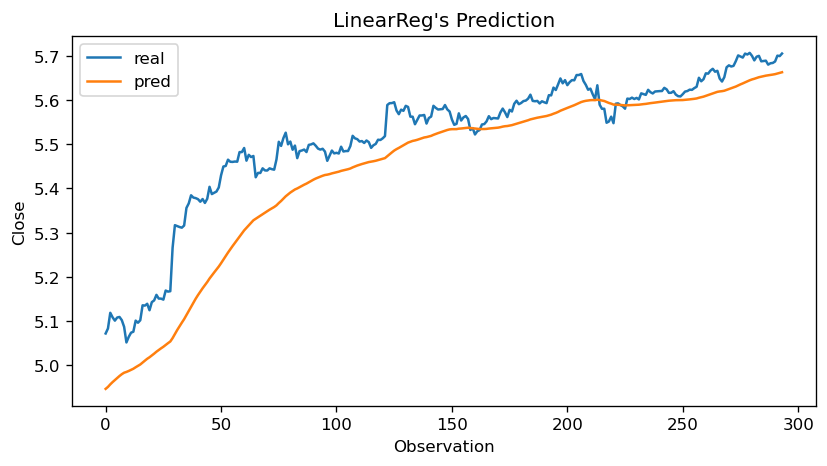

In [89]:
plt.figure(figsize=(8, 4))
plt.plot(y_test, label='real')
plt.plot(y_pred, label='pred')
plt.title("LinearReg's Prediction")
plt.xlabel('Observation')
plt.ylabel('Close')
plt.legend()
plt.show();

In [90]:
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', sqrt(mean_squared_error(y_test, y_pred)))
print("Coefficient of Determination:", r2_score(y_test, y_pred))
print("MAPE", mean_absolute_percentage_error(y_test, y_pred))

Mean Absolute Error: 0.072133513729478
Mean Squared Error: 0.00865870392870805
Root Mean Squared Error: 0.09305215703414967
Coefficient of Determination: 0.6487543914965355
MAPE 0.013276157660055741


In [91]:
import numpy as np

# Assuming model is your trained linear regression model
k = model.coef_.size + 1  # Number of parameters (including the intercept)
n = len(y_train)  # Number of observations
RSS = np.sum((y_pred - y_test) ** 2)  # Residual Sum of Squares

AIC = 2 * k + n * np.log(RSS / n)
print("AIC value:", AIC)

AIC value: -5153.761820953928


# ВЫВОД:

По информационному критерию лучшей моделью также является модель SVR. AIC оказался минимальным, а значит при использовании данной модели происходит наименьшая потеря информации по сравнению с истинной моделью. 
<br>
<br>
По результатам сравнения полученных моделей наилучшей получилась модель регрессии опорных векторов.  SVR способен моделировать как линейные, так и нелинейные зависимости в данных благодаря использованию различных ядерных функций, что позволяет лучше адаптироваться к разнообразным структурам данных.
<br>
<br>
При этом нужно учитывать, что модели целенаправленно были недостаточного оснащены с целью интерперетированности прогноза и во избежание переобучения. Таким образом, использование моделей Data-mining для нестационарных временных рядов может обеспечивать получение более качественного прогноза, что особенно важно в задачах анализа финансового рынка.